In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# 1. Data Preparation:

In [3]:
def prepare_time_order_values(df):
    """
    Prepares order values by time of day.
    """
    # Get only actual purchases
    orders = df[df['revenue'].notna()].copy()
    
    print("Time of day order counts:")
    print(orders['time_of_day'].value_counts())
    print("\nSummary statistics by time of day:")
    print(orders.groupby('time_of_day')['revenue'].agg(['count', 'mean', 'median']))
    
    return orders[['time_of_day', 'revenue']]

orders_data = prepare_time_order_values(df)

Time of day order counts:
time_of_day
night      98
day        75
evening    58
morning    51
Name: count, dtype: int64

Summary statistics by time of day:
             count         mean  median
time_of_day                            
day             75  5625.666667  4999.0
evening         58  5705.896552  4999.0
morning         51  5351.941176  4999.0
night           98  5713.285714  4999.0


# Test normality for each time period:


Normality test results:
  time_of_day  n_orders         mean  shapiro_stat       p_value  normal
0       night        98  5713.285714      0.518646  2.281397e-16   False
1         day        75  5625.666667      0.488664  9.845754e-15   False
2     morning        51  5351.941176      0.379737  2.320284e-13   False
3     evening        58  5705.896552      0.523371  1.919214e-12   False


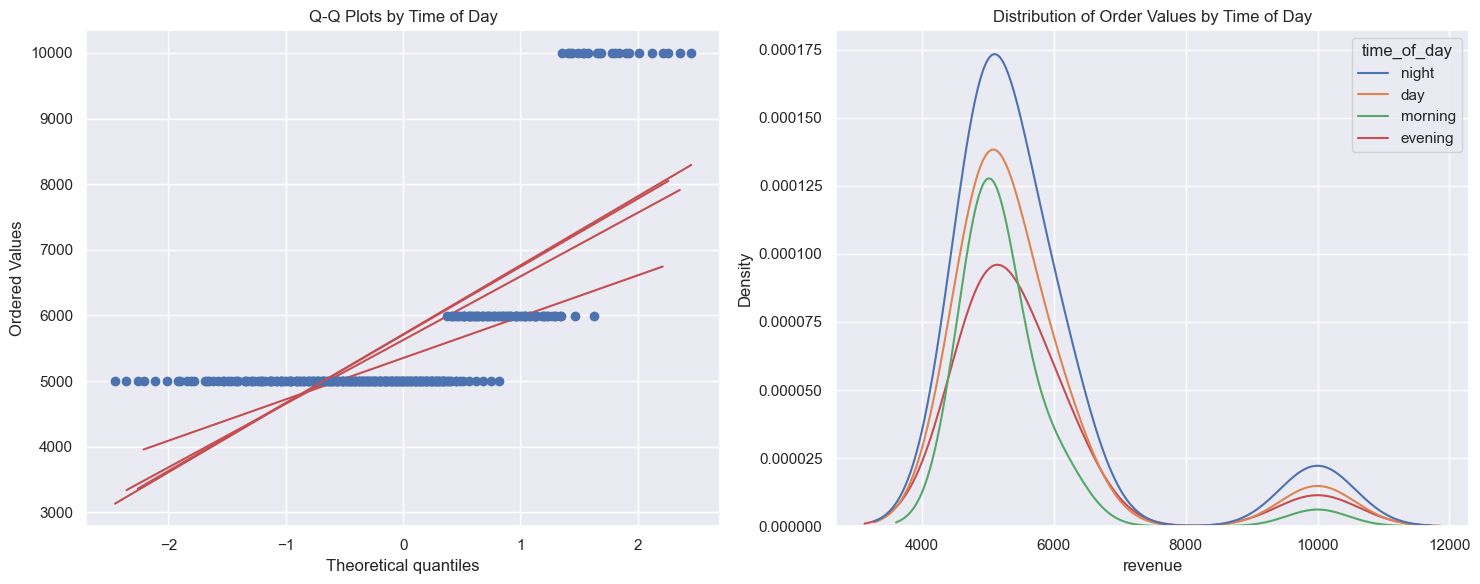

In [4]:
def test_time_order_normality(orders):
    """
    Tests normality of order values for each time of day.
    """
    results = []
    for time_period in orders['time_of_day'].unique():
        time_values = orders[orders['time_of_day'] == time_period]['revenue']
        
        # Shapiro-Wilk test
        stat, pval = stats.shapiro(time_values)
        
        results.append({
            'time_of_day': time_period,
            'n_orders': len(time_values),
            'mean': time_values.mean(),
            'shapiro_stat': stat,
            'p_value': pval,
            'normal': pval > 0.05
        })
    
    return pd.DataFrame(results)

normality_results = test_time_order_normality(orders_data)
print("\nNormality test results:")
print(normality_results)

# Visualize distributions
plt.figure(figsize=(15, 6))

# QQ plot
plt.subplot(1, 2, 1)
for time_period in orders_data['time_of_day'].unique():
    values = orders_data[orders_data['time_of_day'] == time_period]['revenue']
    stats.probplot(values, dist="norm", plot=plt)
plt.title('Q-Q Plots by Time of Day')

# Density plot
plt.subplot(1, 2, 2)
sns.kdeplot(data=orders_data, x='revenue', hue='time_of_day')
plt.title('Distribution of Order Values by Time of Day')
plt.tight_layout()
plt.show()

# Perform Kruskal-Wallis test:

In [5]:
def test_time_order_values(orders):
    """
    Tests differences in order values across times of day.
    """
    # Kruskal-Wallis test
    time_groups = [group['revenue'].values 
                  for _, group in orders.groupby('time_of_day')]
    
    stat, pval = stats.kruskal(*time_groups)
    
    # Get summary statistics
    time_stats = orders.groupby('time_of_day')['revenue'].agg(['count', 'mean', 'median'])
    
    return {
        'statistic': stat,
        'p_value': pval,
        'significant': pval < 0.05,
        'time_stats': time_stats
    }

results = test_time_order_values(orders_data)
print("\nKruskal-Wallis test results:")
print(f"Statistic: {results['statistic']:.4f}")
print(f"P-value: {results['p_value']:.4f}")
print(f"Significant: {results['significant']}")
print("\nTime period statistics:")
print(results['time_stats'])


Kruskal-Wallis test results:
Statistic: 4.4847
P-value: 0.2137
Significant: False

Time period statistics:
             count         mean  median
time_of_day                            
day             75  5625.666667  4999.0
evening         58  5705.896552  4999.0
morning         51  5351.941176  4999.0
night           98  5713.285714  4999.0


### Statistical test shows no significant differences in order values across different times of day (p = 0.2137 > 0.05)

## Order values do NOT significantly differ by time of day. This suggests that customers make purchases of similar values regardless of whether they buy in the morning, during the day, in the evening, or at night. This insight could be valuable for pricing strategies and promotional timing decisions, indicating no need for time-based price differentiation.